Requirements - A checklist to remind us if we tick all the boxes
---------------------
- [ ] Make a nice plot to select a time/ period of interest
- [ ] Run WIT on a per-pixel basis
- [ ] Return Water/Wet/FC percentage per pixel
- [ ] Plot and output WIT spatially, with FC percentage represented as an alpha % for the colour
- [ ] Output the results as a ArcGIS-compliant Geotiff (uint8), with the shapefile name and the date in the filename

Functions or functionalities
---------
- bokeh wit plot: to do a stack plot of wit data with bokeh
    - input: DataFrame
    - output: stack plot of wit data
- load_wit_data(**kwargs)
    - input: csv file or poly_id in database
    - output: DataFrame
- load_wofs_fc(query)
    - input: a query dictionary with time and geometry
    - output: an xarray with water/wet/FC percentage
- plot_spatial_wit(input_pixels_array)
    - input: an xarray with water/wet/FC percentage
    - output: 2 dimensional plot of input
- write_geotiff(input_pixels_array, file_name)
    - input: an xarray with water/wet/FC percentage
            a string as file anme
    - output: a geotiff file with input file name
    
Coding/writing style requirements
-------------------------
- Always break up a sentence if it's too long, slide showing up is a good indicator
- Merge all the cells without essential output unless requied not so, e.g, explanation proceeding a functionality
- Use `_LOG.debug` provided insted of `print`
- Follow the comments in cells to fill in code rather than randomly dump
- Keep all the variables humanly readable, a, b, c or aa, bb, cc etc. simple letters or their permutation are forbidden to be used globally
- Something else I haven't come up with yet

Does the front end plumbing that you're designing for WIT spatial encompass multiple potential sources of WIT?
- Retrieve data from DB
- User uploads WIT CSV file (ie if WA wanted to upload one of the WITs we've just shipped them)
- Retrieve pre-calculated WIT from S3 bucket

Before running this notebook:
-----------------------------
- Check you have the latest version of the `wit_tooling package` by 
copying and pasting the following code into the cell below and running the cell

`!pip install --user git+git://github.com/GeoscienceAustralia/wit_tooling`

In [1]:
# import all the necessary packages in this cell
# check if anything you want is here already with different abbr. with Ctrl+F (maybe there is a better way?
# but you got the idea)
import pandas as pd
import numpy as np
import xarray as xr
import fiona
import yaml
from datacube import Datacube
from datetime import datetime, timedelta
import matplotlib.dates as mdates

from bokeh.io import curdoc, output_notebook, show, push_notebook
from bokeh.layouts import layout, column, row, WidgetBox, gridplot
from bokeh.models import (CheckboxGroup, Select,  CategoricalColorMapper, ColumnDataSource,HoverTool, Label,
                          SingleIntervalTicker, Slider, DatetimeTickFormatter, YearsTicker, Legend, TapTool,
                          CustomJS, LegendItem, field, Range1d)
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.models.glyphs import Text
from bokeh.models.tickers import DatetimeTicker
from bokeh.plotting import figure
from datacube.virtual.impl import VirtualDatasetBox
from datacube.virtual import construct
from datacube.utils.geometry import CRS, Geometry
from shapely.geometry import mapping, box
from enum import Enum
import os, sys, urllib, logging
import seaborn as sns
import matplotlib.pyplot as plt
import ssl

from wit_tooling import query_wit_data, load_timeslice, convert_shape_to_polygon, generate_raster

In [2]:
output_notebook()
ssl._create_default_https_context = ssl._create_unverified_context

_LOG = logging.getLogger('spatial_wit')
stdout_hdlr = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter('[%(asctime)s.%(msecs)03d - %(levelname)s] %(message)s')
stdout_hdlr.setFormatter(formatter)
_LOG.addHandler(stdout_hdlr)
_LOG.setLevel(logging.DEBUG)

Loading BokehJS ...

In [3]:
# put global variables in this cell
# the values of variables can be changed accordingly
shapefile = '/g/data1a/r78/DEA_Wetlands/shapefiles/ramsar_wetlands_3577_20190403.shp'
csv_file = '/g/data1a/u46/users/ea6141/dea-notebooks/Spatial_WIT/sample_data/Western Port_Western Port_VIC_19.csv'
pd_yaml = '/g/data/u46/users/ea6141/wit_tooling/aux/fc_pd.yaml'
s3_url = 'https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/Wetlands_Insight_Tool/WIT_v3'

Here is the start of all functions
----------------------------------------------
Note: Put each function in a cell

In [15]:
def bokeh_WIT_plot(WITdata, polyName='provided polygon'):
    '''
    last modified: May 2020
    
    Parameters
    ----------
    WITdata : xarray data array produced by load_wit_data function
    polyName : string
               A name for the polygon to identify the plot, optional. Defaults to 'provided polygon' 
                   
    Returns
    -------
    A bokeh stack plot of the contents of the vector file in water, wet, green, dry and bare. Plot can be zoomed in to select a date. 
    '''
    
    #set up color palate for bokeh WIT plot
    pal = [sns.xkcd_rgb["cobalt blue"],
           sns.xkcd_rgb["neon blue"],
           sns.xkcd_rgb["grass"],
           sns.xkcd_rgb["beige"],
           sns.xkcd_rgb["brown"]]  

    #these are tools we want to use in the plot
    TOOLS = ["pan, wheel_zoom, box_zoom, reset, tap, save"]

    #lets put a title on the plot
    title =f'Percentage of area dominated by WOfS, Wetness, Fractional Cover for {polyName}'    

    #set up the x axis to recognise date and time. Note that you will only see the days when you zoom in.
    p =figure(plot_width=1200, 
              plot_height = 400, 
              x_axis_type='datetime',
             title=title, tools=TOOLS)
    p.sizing_mode = "scale_width"

    #align the title in the centre
    p.title.align= "center"
    p.title.text_font_size="12pt"

    #label axes
    p.yaxis.axis_label=("percentage of polygon classified as type")
    p.yaxis.axis_label_text_font_size="8pt"

    #we need screen units to put the attribution label under the plot. Don't ask why.
    label_opts = dict(
        x=0, 
        y=0,
        x_units='screen', 
        y_units='screen',
        text_font_style="italic", 
        text_font_size="8.5pt")
    
    #underplot context
    msg1 = 'The Fractional Cover algorithm developed by the Joint Remote Sensing Research Program\n\
    and the Water Observations from Space algorithm developed by Geoscience Australia are used in the production of this data'
    caption1 = Label(text=msg1, **label_opts)

    p.add_layout(caption1, 'below')

    p.xaxis.formatter=DatetimeTickFormatter(years =["%Y"], months=["%m/%Y"] ,days=["%d/%m/%Y"])
    p.xaxis.major_label_orientation = 45

    #create the actual stack plot using data from the pandas dataframe 
    p.varea_stack(['water', 
                  'wet',
                  'green',
                  'dry',
                  'bare'], x= 'utc_time', color=pal, fill_alpha=0.7, source = WITdata, 
                  legend_label=["water","wet","green","dry","bare"], muted_color="grey", muted_alpha=0.2)


    #set the new WIT graph ranges.
    left, right, bottom, top = WITdata.index[0], WITdata.index[-1], 0, 100 #set 
    p.x_range=Range1d(left, right)
    p.y_range=Range1d(bottom, top)
    p.xaxis.bounds=(left,right)
    p.yaxis.bounds=(bottom,top)

    #now we want to overplot the data on the plot
    #create rectangle borders for no-data times (SLC-off only)
    LS5_8_gap_start = datetime(2011,11,1)
    LS5_8_gap_end = datetime(2013,4,1)

    #plot our dead satellite rectangle
    p.hbar(y=50, 
           height=100,
           left=LS5_8_gap_start, 
           right=LS5_8_gap_end, 
           color="white", 
           alpha=0.5, 
           hatch_color="white", 
           hatch_pattern='/',
           hatch_alpha=0.6,
           line_color="white",
           line_width =2,
           line_alpha=0.6)

    p.legend
    p.legend.location="bottom_left"
    p.legend.click_policy="mute"
    p.legend.background_fill_alpha=0.5
    p.legend.border_line_alpha=0.5
    p.legend.label_text_font_size="9pt" 

    #reverse the legend 
    p.legend[0].items.reverse()


    return p


In [5]:
def rename_columns(wit_df):
    #give the index a name that reflects that it is time, measured in UTC not AEDT/AEST
    wit_df = wit_df.set_index('TIME')
    wit_df.index.name = 'utc_time'
    #format the index of the dataframe as a date, not as a string
    wit_df.index = pd.to_datetime(wit_df.index)
    #Rename the columns so they are easier to understand and plot
    wit_df = wit_df.rename(columns={"WATER" : "water", 
                            "WET" : "wet",
                           "PV" : "green",
                           "NPV" : "dry",
                           "BS" : "bare"}) 
    #converting to percentages to make plotting easier
    #first convert if not already a percentage
    if wit_df.max().max() <=1.0:
        wit_df = wit_df*100
    #WITdata.head()
    return wit_df

In [6]:
def load_wit_data(**kwargs):
    """
        input parameters:
            csv: csv file path
            shape: a shape from shape file
            s3_url: s3 bucket path
        output:
            panda dataframe of wit data
    """
    if kwargs.get("csv") is not None:
        wit_data = pd.read_csv(kwargs['csv'])
    elif kwargs.get('shape') is not None:
        _, wit_data = query_wit_data(kwargs['shape'])
        wit_data = pd.DataFrame(data=wit_data, columns=['TIME', 'BS', 'NPV', 'PV', 'WET', 'WATER'])
    elif kwargs.get('s3_url') is not None:
        wit_data = pd.read_csv(kwargs['s3_url'], infer_datetime_format=True)
    return wit_data

In [7]:
def construct_product(product_yaml):
    with open(product_yaml, 'r') as f:
        recipe = yaml.safe_load(f)
    fc_product = construct(**recipe)
    return fc_product

def query_datasets(fc_product, shape, crs, time_range):
    dc = Datacube()
    query_poly = convert_shape_to_polygon(shape['geometry'])
    query_poly = Geometry(mapping(box(*query_poly.bounds)), CRS(crs))
    query = {'geopolygon': query_poly, 'time': time_range}
    datasets = fc_product.query(dc, **query)
    grouped = fc_product.group(datasets, **query)
    return grouped

def load_wofs_fc(fc_product, grouped, time_slice):
    if not (isinstance(time_slice, list) or isinstance(time_slice, tuple)):
         time_slice = [time_slice]
    to_load = VirtualDatasetBox(grouped.box.loc[time_slice], grouped.geobox,
                grouped.load_natively, grouped.product_definitions, grouped.geopolygon)
    fc_wofs_data = load_timeslice(fc_product, to_load)
    return fc_wofs_data

In [8]:
def spatial_wit(fc_wofs_data, mask):
    none_water_vars = list(fc_wofs_data.data_vars)[:-1]
    water_var = list(fc_wofs_data.data_vars)[-1]
    fc_data = fc_wofs_data[none_water_vars].where(fc_wofs_data[water_var] < 1, 0)
    tcw_percent = fc_data['TCW'] >= -350
    fc_percent = fc_data.drop('TCW').where(~tcw_percent, 0)
    fc_wofs_perc = xr.merge([fc_percent, (tcw_percent.astype("int") * 100),
                             (fc_wofs_data[water_var].astype("int") * 100)])
    fc_wofs_perc = fc_wofs_perc.where(mask == int(shape['id']), -127).astype("int16")
    fc_wofs_perc.attrs.update(fc_wofs_data.attrs)
    return fc_wofs_perc

Here is the start of all non function functionalities
------------------------------------------------------------------------
Note: Keep a single functionality in a SINGLE cell; DONOT make functionalities tangled 

In [9]:
# load wit data from database with a chosen shape
with fiona.open(shapefile) as allshapes:
    shape_crs = allshapes.crs_wkt
    shape = next(iter(allshapes))
    wit_data = load_wit_data(shape=shape)
# or load from s3 bucket
# s3_filename = 'Kerang%20Wetlands_Hird%20Swamp_VIC_17.csv'
# wit_data = load_wit_data(s3_url='/'.join([s3_url, s3_filename]))
# or load from local csv
# wit_data = load_wit_data(csv=csv_file)
wit_data = rename_columns(wit_data)
wit_data

,bare,dry,green,wet,water
utc_time,,,,,
1987-05-22 23:07:43.500,3.01791,7.79725,14.3224,64.023,10.5532
1987-09-11 23:10:29.500,4.10354,10.0363,16.2926,55.1768,14.0152
1987-10-29 23:11:25.000,4.27089,11.4134,20.8895,54.5629,8.42139
1988-01-17 23:12:49.500,0.952721,3.0068,6.57585,58.0272,31.3265
1988-02-18 23:13:23.000,2.24369,4.65846,10.6758,68.2449,13.9836
...,...,...,...,...,...
2019-08-02 23:43:46.500,1.85417,5.03441,9.16793,68.4343,15.3093
2019-08-18 23:43:52.000,4.11364,7.19539,12.1787,61.0164,15.2146
2019-09-03 23:43:55.000,1.80381,6.96089,12.444,64.7716,13.7364


In [10]:
#put in the name of your polygon here (or extract it from something else?)
polyName = "Hird Swamp" #change this as appropriate

In [16]:
plot = bokeh_WIT_plot(wit_data, polyName)
show(plot)

In [12]:
# load a(more) time slice(s)
# it's helpful to get the location of data rather than load them
# and it will save you time without querying database multiple times, which is very slow in case you don't know
time_range = (wit_data.index.min(), wit_data.index.max())
fc_product = construct_product(pd_yaml)
datasets = query_datasets(fc_product, shape, shape_crs, time_range)
_LOG.debug("Query datasets %s", datasets)

[2020-05-27 13:20:45,481.481 - DEBUG] Query datasets <VirtualDatasetBox of shape {'time': 572, 'y': 76, 'x': 85}>


In [13]:
# then decide with slice(s) you want to load
# e.g. 1988-02-18 23:13:23.000  in wit_data concers you
time_slice = np.datetime64(wit_data.index[4])
_LOG.debug("load time slice %s", time_slice)
fc_wofs_data = load_wofs_fc(fc_product, datasets, time_slice)
# first parameter is a tuple of (gemoetry, a_int)
mask = generate_raster([(shape['geometry'], int(shape['id']))], datasets.geobox)
fc_wofs_perc = spatial_wit(fc_wofs_data, mask)

[2020-05-27 13:20:45,491.491 - DEBUG] load time slice 1988-02-18T23:13:23.000000


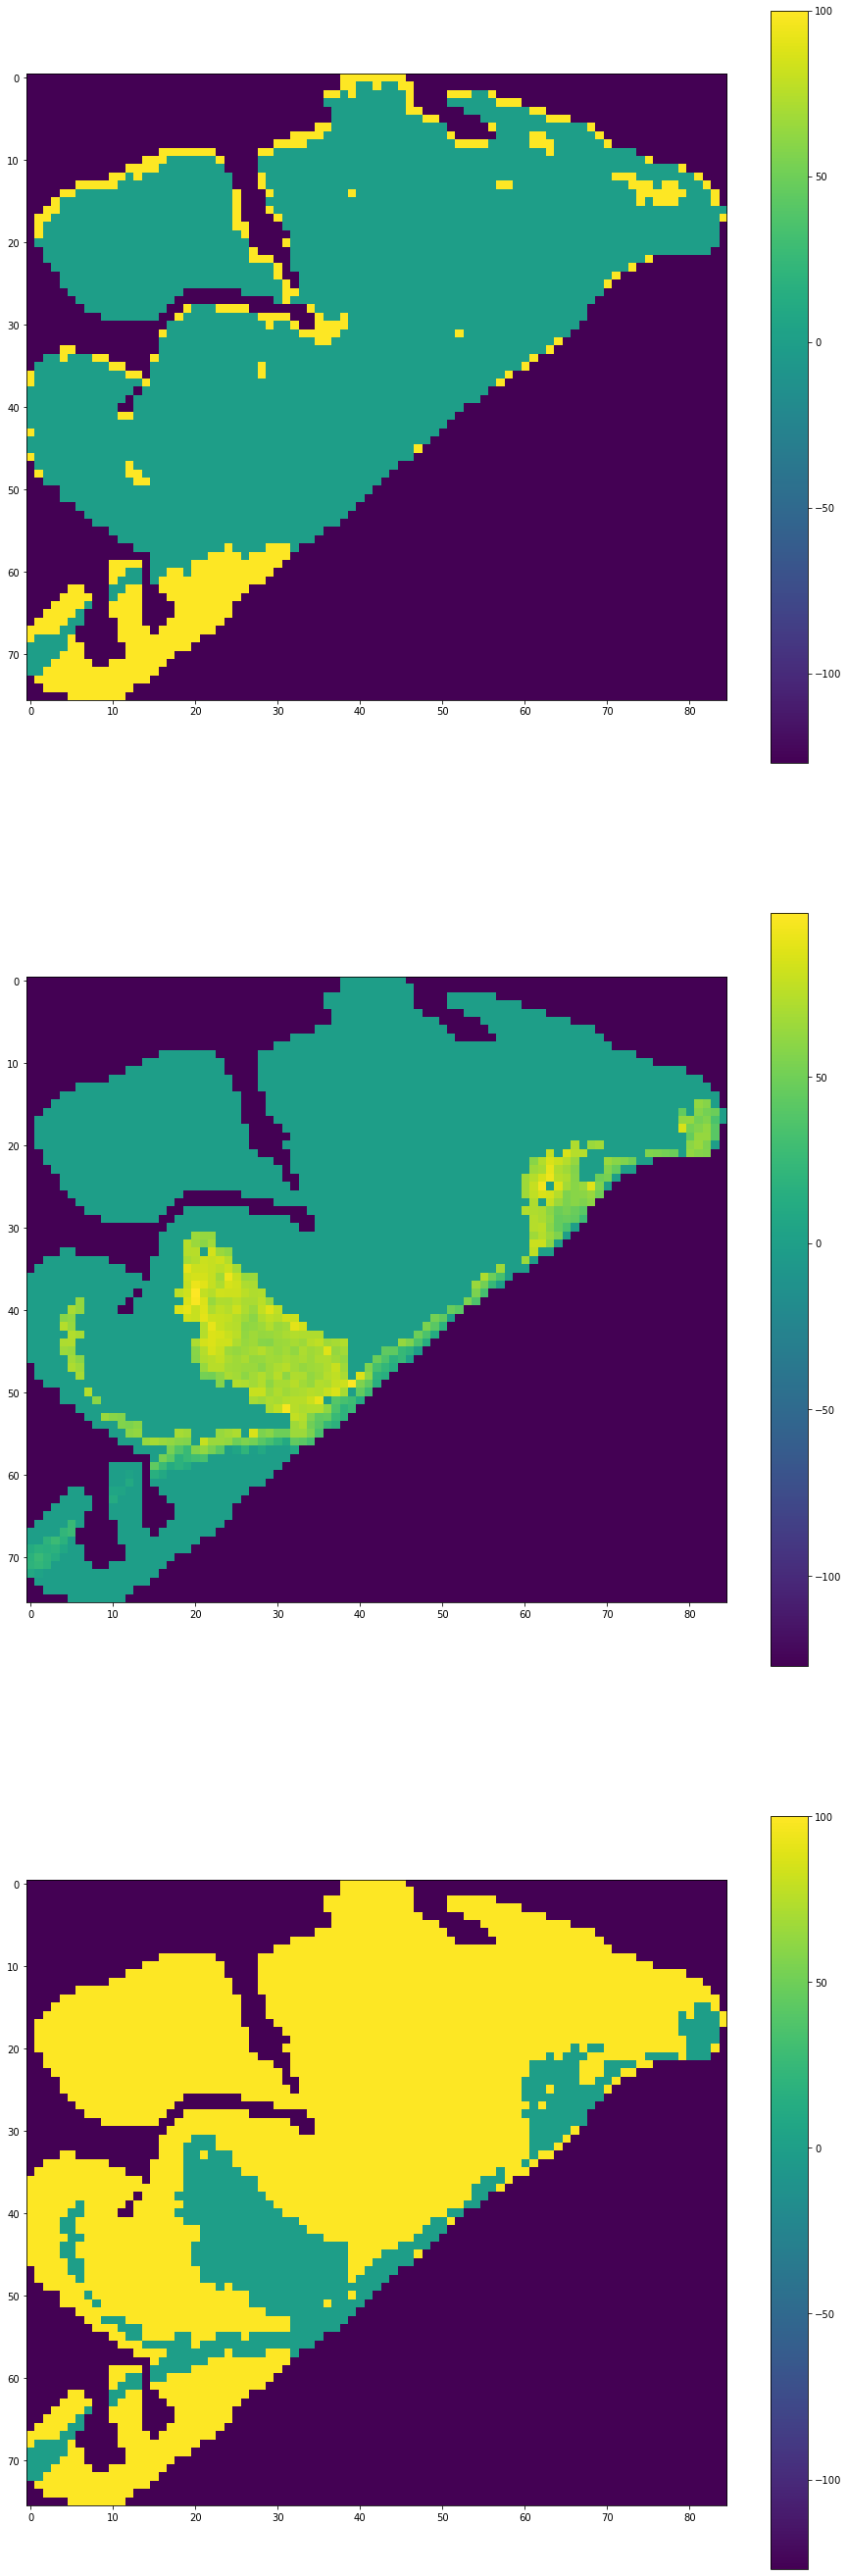

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(16, 48))
im1 = ax[0].imshow((fc_wofs_perc.water)[0].data)
im2 = ax[1].imshow((fc_wofs_perc.PV)[0].data)
im3 = ax[2].imshow((fc_wofs_perc.TCW)[0].data)
fig.colorbar(im3, ax=ax[2])
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])